In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def extract_frames(video_path, frame_interval=2):
    cap = cv2.VideoCapture(video_path)
    frames = []
    timestamps = []
    
    if not cap.isOpened():
        print("Error: Unable to open video file.")
        return frames, timestamps
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval_frames = int(fps * frame_interval)
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frames.append(frame)
        timestamps.append(cap.get(cv2.CAP_PROP_POS_MSEC) / 1000)  # Convert milliseconds to seconds
        
        # Skip frames to maintain time interval
        for _ in range(frame_interval_frames):
            cap.grab()
    
    cap.release()
    return frames, timestamps

In [5]:
def extract_sift_features(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return keypoints, descriptors

In [6]:
def compute_scene_overlap(frame1, frame2):
    kp1, des1 = extract_sift_features(frame1)
    kp2, des2 = extract_sift_features(frame2)
    
    # Match keypoints between frames
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    matches = matcher.knnMatch(des1, des2, k=2)
    
    # Count the number of matches
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
    scene_overlap = len(good_matches) > 10  # Adjust threshold as needed
    
    return scene_overlap

In [7]:
def select_image_pair(frames, timestamps, min_time_diff=2):
    num_frames = len(frames)
    selected_pair = None
    
    for i in range(num_frames - 1):
        if timestamps[i + 1] - timestamps[i] >= min_time_diff:
            selected_pair = (frames[i], frames[i + 1])
            break
    
    return selected_pair


In [8]:
def select_corresponding_pixels(image1, image2, patch_size=5):
    # Select random pixel coordinates from image1
    h1, w1 = image1.shape[:2]
    x1 = np.random.randint(patch_size, w1 - patch_size)
    y1 = np.random.randint(patch_size, h1 - patch_size)
    
    # Corresponding pixel coordinates in image2
    # Assuming there is some translation between the images
    # Adjust these coordinates according to the transformation between the images
    x2 = x1 + np.random.randint(-10, 10)
    y2 = y1 + np.random.randint(-10, 10)
    
    return (x1, y1), (x2, y2)

In [9]:
def compute_ssd(des1, des2):
    return np.sum(np.square(des1 - des2))

SSD value between SIFT vectors: 110502910
Homography matrix:
[[ 1.13900952e+00  1.45252362e-02 -1.79150197e+02]
 [ 7.61831441e-02  1.07339451e+00 -1.10306266e+01]
 [ 2.27175542e-04  6.95329882e-06  1.00000000e+00]]
Inverse homography matrix:
[[ 8.48498831e-01 -1.24657355e-02  1.51871228e+02]
 [-6.21978044e-02  9.32471135e-01 -8.57008005e-01]
 [-1.92325702e-04 -3.65184024e-06  9.65504531e-01]]


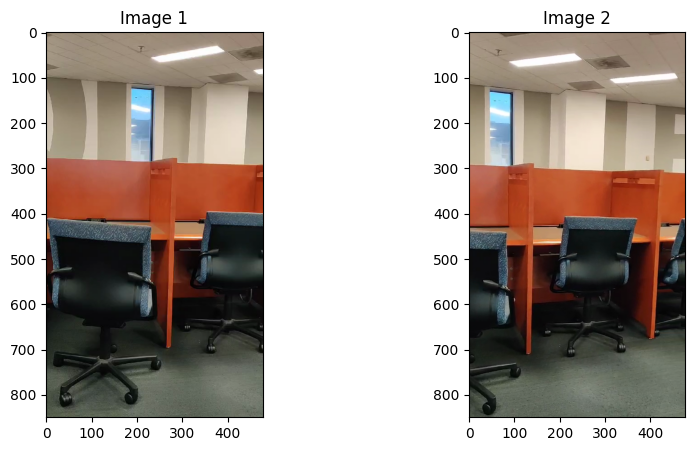

In [10]:
def estimate_homography(image1, image2):
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    matches = matcher.knnMatch(des1, des2, k=2)
    
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    
    if len(good_matches) > 10:  # Adjust threshold as needed
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H
    
    return None

# Load video frames and timestamps
video_path = "static/SampleVideo.mp4"
frames, timestamps = extract_frames(video_path, frame_interval=2)

# Select image pair
selected_pair = select_image_pair(frames, timestamps, min_time_diff=2)

# Compute scene overlap
overlap = compute_scene_overlap(selected_pair[0], selected_pair[1])

# Select corresponding pixels
pixel1, pixel2 = select_corresponding_pixels(selected_pair[0], selected_pair[1], patch_size=5)

# Compute SSD
ssd_value = compute_ssd(selected_pair[0], selected_pair[1])
print("SSD value between SIFT vectors:", ssd_value)

# Estimate homography
homography_matrix = estimate_homography(selected_pair[0], selected_pair[1])

# Print homography matrix
print("Homography matrix:")
print(homography_matrix)

# Compute inverse homography matrix
inverse_homography_matrix = np.linalg.inv(homography_matrix)

# Print inverse homography matrix
print("Inverse homography matrix:")
print(inverse_homography_matrix)

# Display the two images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(selected_pair[0][:, :, ::-1])  # Convert BGR to RGB for display
plt.title("Image 1")

plt.subplot(1, 2, 2)
plt.imshow(selected_pair[1][:, :, ::-1])  # Convert BGR to RGB for display
plt.title("Image 2")

plt.show()
